# Lab 1: Comparison of the Tensile Properties of the Collateral Ligaments

## Data Analysis

Goals for this lab report:

- **Hypotheses:** What is the effect of the test variable (MCL vs LCL) on
  - Stiffness, $k$
  - Tangent Elastic Modulus, $E$
- Present $\text{mean}\pm\text{std. dev.}$ and perform statistical tests for:
  - Geometric Dimensions: $L_0$, $w$, $t$
  - Cross-sectional area, $A$
  - Stiffness, $k$ (T-Test)
  - Tangend Elastic Modulus, $E$ (T-Test)

In [1]:
# Google Colab: Run this to mount your Google Drive

# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

## Import necessary libraries
### Data analysis
from scipy import stats
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

import sys
sys.path.append('../')
import tools

### Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Setup
from pathlib import Path
import re
import os

## Define the paths to raw data and results
datapath = Path('data')

In [26]:
# Load data

## Regular expression to pull sample and team information from file name
meta = re.compile(r"(?P<tissue>[ml]cl)(?P<team>\d{2})")

## Load all data into a list
data = []
for file in datapath.glob("lab1*.csv"):

    ## Extract sample and team information from file name
    match = meta.search(file.name)

    ## Load data
    try:
        _df = tools.load_data(file)
        _df['tissue'] = match.group('tissue').upper()
        _df['team'] = match.group('team')
        data.append(_df)
    except AssertionError as e:
        print(f"Error loading {file.name}: {e}")

## Concatenate all data into a single dataframe
data = pd.concat(data).reset_index(drop=True)
display(data.head())

## Load specimen dimensions
specimen = pd.read_excel(datapath / 'lab1_specimen_dimensions.xlsx')

,time,disp,load,tissue,team
0,0.0000,-2.000176,-0.01,LCL,02
1,0.1464,-1.986490,-0.01,LCL,02
2,0.2928,-1.974538,-0.01,LCL,02
3,0.4392,-1.964746,-0.01,LCL,02
4,0.5856,-1.952381,-0.01,LCL,02


## Raw Data Visualization

**Preconditioning:** $t > 120s$

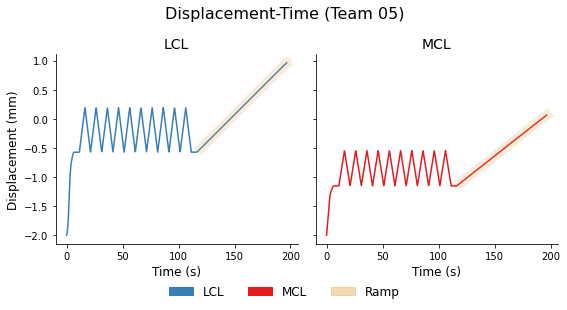

In [27]:
# Disp vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='disp',
    xlab='Time (s)',
    ylab='Displacement (mm)',
    title='Displacement-Time (Team 05)',
    highlight_ramp=True,
    ramp_time=120
)

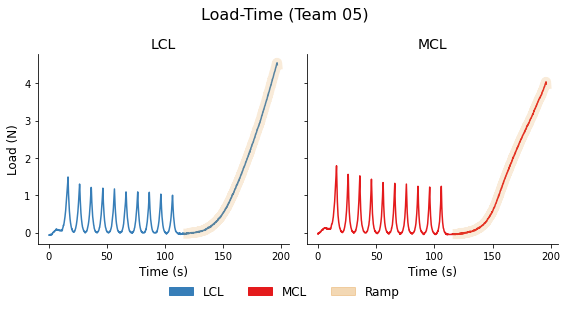

In [28]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 05)',
    highlight_ramp=True,
    ramp_time=120
)

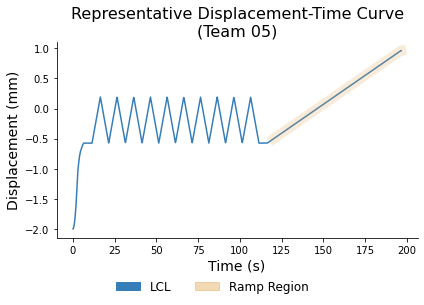

In [29]:
I = (data['team'] == '05') & (data['tissue'] == 'LCL')
        
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(data=data.loc[I], x='time', y='disp', color='#377eb8',
             ax=ax)
sns.lineplot(data=data.loc[I & (data['time'] > 120)], x='time', y='disp',
             color='#e39e44', ax=ax, linewidth=10, alpha=.2)

ax.set_title('Representative Displacement-Time Curve\n(Team 05)', 
             fontsize=16)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('Displacement (mm)', fontsize=14)
sns.despine()

lcl = mpatches.Patch(color='#377eb8', label='LCL')
ramp = mpatches.Patch(color='#e39e44', alpha=.4, label='Ramp Region')
fig.legend(handles=[lcl, ramp], loc='upper center', 
           bbox_to_anchor=(0.5, 0.05), ncol=3, fancybox=False,
           shadow=False, fontsize=12, frameon=False)

# fig.subplots_adjust(top=0.9)
# fig.suptitle(title, fontsize=16)
plt.tight_layout()

## Visualization: Stress & Strain

$$ \text{Stress, } \sigma = \frac{F}{w \cdot t} $$

$$ \text{Strain, } \varepsilon = \frac{\Delta L}{L_0} $$

Figures from this point only include the 'ramp' data.

In [30]:
# Exclude preconditioning data and shift displacement to start at 0
data = data.loc[data['time'] > 120].copy()

# Shift displacement and time to start at 0 (Done separately for each team)
for team in data['team'].unique():
    I = data['team'] == team
    data.loc[I, 'disp'] = (data.loc[I]
        .groupby('tissue')['disp']
        .apply(lambda x: x - x.iloc[0]))
    data.loc[I, 'time'] = (data.loc[I]
        .groupby('tissue')['time']
        .apply(lambda x: x - x.iloc[0]))

In [31]:
# Compute stress and strain
for team in data['team'].unique():
    for tissue in ['MCL', 'LCL']:
        I = (data['team'] == team) & (data['tissue'] == tissue)
        J = (specimen['Group #'] == int(team)) & (specimen['Ligament'] == tissue)

        # Stress
        A = (specimen.loc[J, 'Width (mm)'] * specimen.loc[J, 'Thickness (mm)']).values[0]
        data.loc[I, 'stress'] = data.loc[I, 'load'] / A

        # Strain
        L0 = specimen.loc[J, 'Gauge length (mm)'].values[0]
        data.loc[I, 'strain'] = data.loc[I, 'disp'] / L0

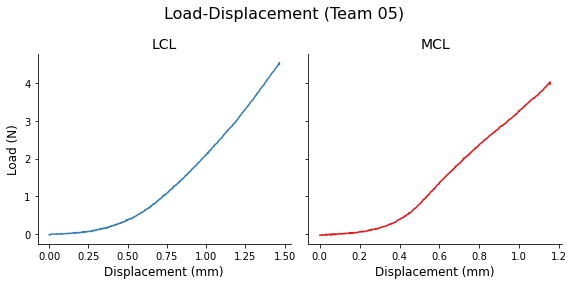

In [32]:
# Load vs Displacement
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='disp',
    yvar='load',
    xlab='Displacement (mm)',
    ylab='Load (N)',
    title='Load-Displacement (Team 05)',
    highlight_ramp=False
)

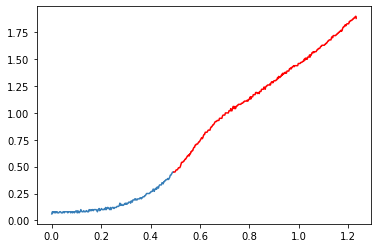

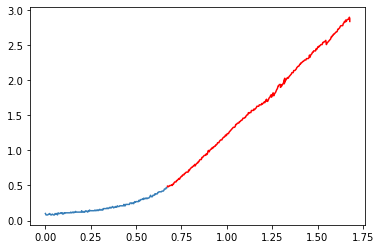

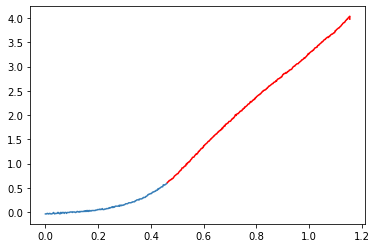

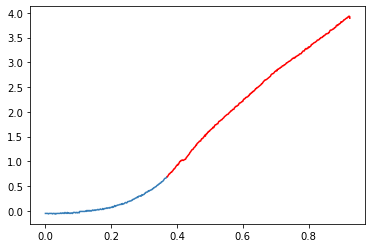

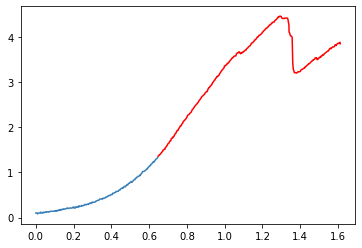

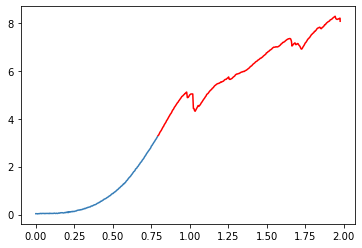

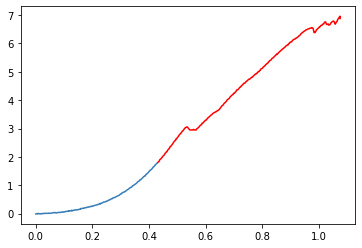

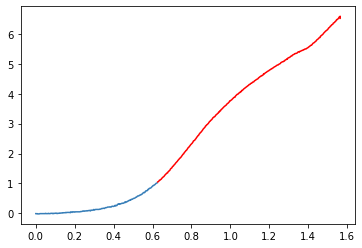

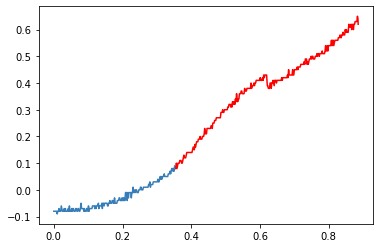

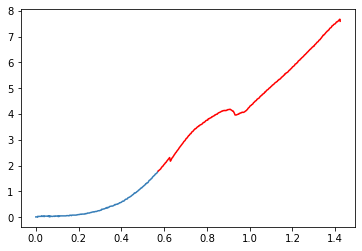

In [45]:
for t in data['team'].unique():
    fig, ax = plt.subplots()

    d = data.query(f"team == '{t}' & tissue == 'MCL'")

    cutoff = round(d.shape[0] * .4)

    ax.plot(d['disp'][:cutoff], d['load'][:cutoff], color='#377eb8')
    ax.plot(d['disp'][cutoff:], d['load'][cutoff:], color='red')

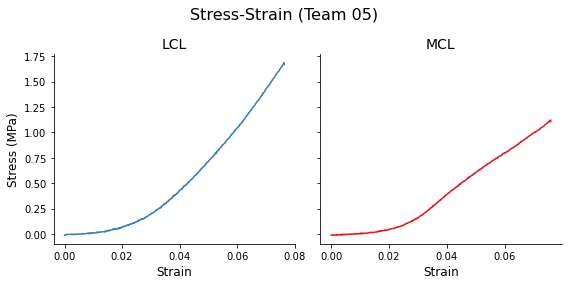

In [10]:
# Stress vs Strain
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='strain',
    yvar='stress',
    xlab='Strain',
    ylab='Stress (MPa)',
    title='Stress-Strain (Team 05)',
    highlight_ramp=False
)

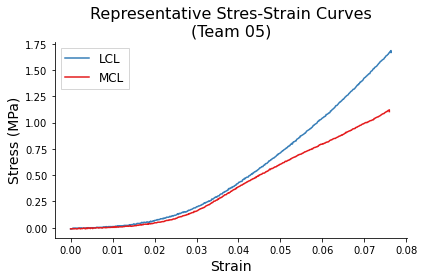

In [11]:
I = (data['team'] == '05') & (data['tissue'] == 'LCL')
J = (data['team'] == '05') & (data['tissue'] == 'MCL')
        
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(data=data.loc[I], x='strain', y='stress', color='#377eb8',
             ax=ax, label='LCL')
sns.lineplot(data=data.loc[J], x='strain', y='stress', color='#e41a1c',
             ax=ax, label='MCL')

ax.set_title('Representative Stres-Strain Curves\n(Team 05)', 
             fontsize=16)
ax.set_xlabel('Strain', fontsize=14)
ax.set_ylabel('Stress (MPa)', fontsize=14)
sns.despine()

ax.legend(frameon=True, fancybox=False, fontsize=12);

plt.tight_layout()

### Weird Data

After looking the Stress-Strain plots for each team, I noticed that there were 
two tests with significant discontinuities at higher stresses.

- Team 09: LCL
- Team 10: MCL

I decided to exculde the discontinuous portion of the data from the curve fit.
In the code cells below, I plot the original data before excluding the points 
from the analysis.

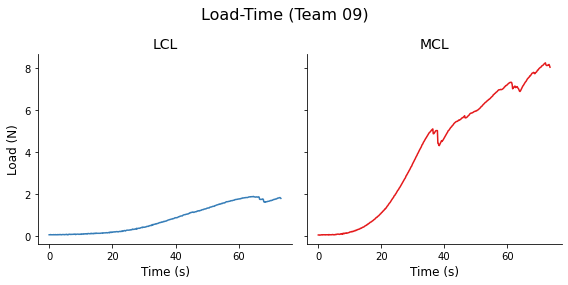

In [12]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 09)',
    team='09'
)

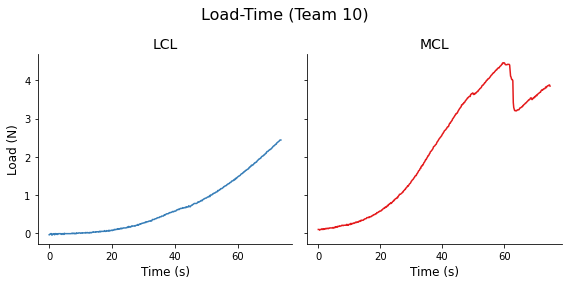

In [13]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 10)',
    team='10'
)

## Curve Fitting: Estimate $E$ and $k$


$$ \sigma = E \cdot \varepsilon $$
$$ F = k\cdot \Delta L $$
$$ k = \frac{E \cdot A}{L_0} $$


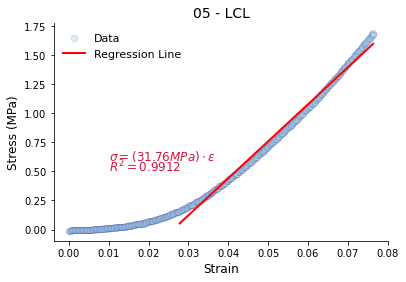

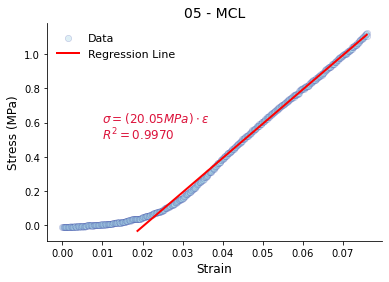

R^2 didn't converge after 40% of the data was removed


,tissue,team,E (MPa),k (N/mm)
0,LCL,02,4.833454,1.325463
1,MCL,08,8.612916,2.351042
2,LCL,08,10.227016,1.363602
3,MCL,05,20.046602,4.747879
4,MCL,04,17.606195,5.711278
5,LCL,10,19.895183,4.504570
6,MCL,09,21.751233,4.857775
7,MCL,10,9.433230,3.074534
8,LCL,04,21.076802,2.965674
9,LCL,03,13.323036,4.946177


In [14]:
# Create new dataframe to store results
test_data = (data[['tissue', 'team']]
    .drop_duplicates()
    .reset_index(drop=True))

axes = []

for tissue in ['LCL', 'MCL']:
    for team in data['team'].unique():
        # Subset data
        I = (data['team'] == team) & (data['tissue'] == tissue)
        _data = data.loc[I].copy()

        # Find linear region
        i, _ = tools.get_linear_region(_data)

        # Fit linear model
        mdl = smf.ols('stress ~ strain', data=_data[i:]).fit()

        # Compute tissue properties
        J = (specimen['Group #'] == int(team)) & (specimen['Ligament'] == tissue)

        ## Elastic Modulus = Slope
        E = mdl.params['strain']  ## MPa

        # Stiffness = Slope * Area / Gauge Length
        A = (specimen.loc[J, 'Width (mm)'] * specimen.loc[J, 'Thickness (mm)']).values[0]
        L0 = specimen.loc[J, 'Gauge length (mm)'].values[0]
        k = E * A / L0  ## N/mm

        # Plot
        if team in ['05']: # ['05', '09', '10']:
            fig, ax = tools.plot_regression(_data, mdl, i, f'{team} - {tissue}')
            axes.append(ax)
            plt.show() 

        # Store results
        K = (test_data['tissue'] == tissue) & (test_data['team'] == team)
        test_data.loc[K, 'E (MPa)'] = E
        test_data.loc[K, 'k (N/mm)'] = k       

# Display and save results
test_data.to_excel(datapath / 'lab1_test_data.xlsx');
display(test_data)

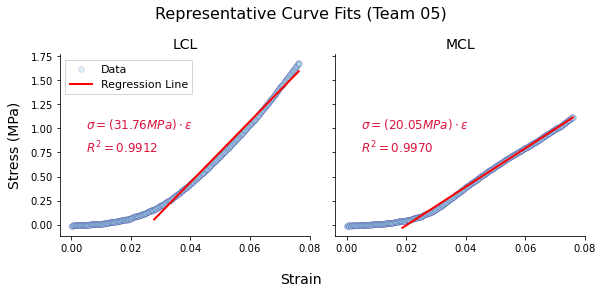

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8.5,4), sharey=True, sharex=True)

for tissue, ax in zip(['LCL', 'MCL'], axes):
    # Subset data
    I = (data['team'] == '05') & (data['tissue'] == tissue)
    _data = data.loc[I].copy()

    # Find linear region
    i, _ = tools.get_linear_region(_data)

    # Fit linear model
    mdl = smf.ols('stress ~ strain', data=_data[i:]).fit()

    # Compute tissue properties
    J = (specimen['Group #'] == int(team)) & (specimen['Ligament'] == tissue)

    ## Elastic Modulus = Slope
    E = mdl.params['strain']  ## MPa

    # Stiffness = Slope * Area / Gauge Length
    A = (specimen.loc[J, 'Width (mm)'] * specimen.loc[J, 'Thickness (mm)']).values[0]
    L0 = specimen.loc[J, 'Gauge length (mm)'].values[0]
    k = E * A / L0  ## N/mm

    # Compute predictions
    pred = mdl.get_prediction().summary_frame(alpha=0.05)
    pred['strain'] = _data['strain'][i:].values

    # Equation label
    eqn = r"$\sigma = (%.2f MPa) \cdot \varepsilon$" % mdl.params['strain']
    r2 = r"$R^2 = %.4f$" % mdl.rsquared

    # Plot
    sns.scatterplot(
        data=_data, x='strain', y='stress',  label='Data', 
        s=30, color='lightblue', edgecolor='darkblue', linewidth=0.3, 
        alpha=.4, ax=ax,
    )
    sns.lineplot(
        data=pred, x='strain', y='mean', label='Regression Line',
        color='red', linewidth=2, ax=ax
    )
    ax.annotate(
        eqn, xy=(0.005, 1.0), xycoords='data', fontsize=12, color='crimson'
    )
    ax.annotate(
        r2, xy=(0.005, 0.75), xycoords='data', fontsize=12, color='crimson'
    )
    if tissue == 'MCL':
        ax.get_legend().remove()
    else:
        ax.legend(fancybox=False, fontsize=11)
    ax.set_title(tissue, fontsize=14)
    ax.set_xlabel('', fontsize=0)
    ax.set_ylabel('', fontsize=0)
    sns.despine()

fig.subplots_adjust(top=0.9)
fig.suptitle('Representative Curve Fits (Team 05)', fontsize=16)
fig.supxlabel('Strain', fontsize=14)
fig.supylabel('Stress (MPa)', fontsize=14)
plt.tight_layout()

In [19]:
# T-Test to Compare LCL and MCL
## Assumptions:
### 1. Normality
### 2. Equal Variance
### 3. Independent Samples


ttest = stats.ttest_ind(
    test_data.loc[test_data['tissue'] == 'MCL', ['E (MPa)', 'k (N/mm)']].values,
    test_data.loc[test_data['tissue'] == 'LCL', ['E (MPa)', 'k (N/mm)']].values,
    axis=0
)
print(f"""
T-Test Results:
    E: t = {ttest[0][0]:.4f}, p = {ttest[1][0]:.4f}
    k: t = {ttest[0][1]:.4f}, p = {ttest[1][1]:.4f}
""")


T-Test Results:
    E: t = 0.4057, p = 0.6898
    k: t = 1.7438, p = 0.0982



In [20]:
specimen['Cross-Sectional Area (mm^2)'] = specimen['Width (mm)'] * specimen['Thickness (mm)']

In [24]:
means = (specimen
    .groupby('Ligament')
    [['Gauge length (mm)', 'Cross-Sectional Area (mm^2)', 'Width (mm)', 'Thickness (mm)']]
    .mean()
    .merge(test_data.groupby('tissue').mean(), left_index=True, right_index=True))

std = (specimen
    .groupby('Ligament')
    [['Gauge length (mm)', 'Cross-Sectional Area (mm^2)', 'Width (mm)', 'Thickness (mm)']]
    .std()
    .merge(test_data.groupby('tissue').std(), left_index=True, right_index=True))

In [25]:
results = {}
for tissue in ['MCL', 'LCL']:

    results[tissue] = {}

    for metric in means.columns:
        results[tissue][metric] = f"{means.loc[tissue, metric]:.2f} +/- {std.loc[tissue, metric]:.4f}"

display(pd.DataFrame.from_dict(results).T)

,Gauge length (mm),Cross-Sectional Area (mm^2),Width (mm),Thickness (mm),E (MPa),k (N/mm)
MCL,18.05 +/- 4.9332,5.83 +/- 2.1147,6.51 +/- 0.5840,0.89 +/- 0.2923,15.21 +/- 9.6029,4.37 +/- 2.2650
LCL,14.52 +/- 3.3072,3.06 +/- 1.3539,3.90 +/- 0.8341,0.77 +/- 0.2163,13.55 +/- 8.6381,2.82 +/- 1.6716
